In [4]:
import ROOT
import numpy as np

# 打开包含 TTree 的文件
file = ROOT.TFile("/Users/sulfone/work/Constrained-Diffusion-Decomposition-main/outskyFlux-new.root", "READ")

Welcome to JupyROOT 6.28/04


In [ ]:
step = 0.1
wcs_icrs = WCS(naxis=2)
wcs_icrs.wcs.ctype = ['RA---CAR', 'DEC--CAR']
wcs_icrs.wcs.crval = [180, 0]
wcs_icrs.wcs.crpix = [1799.5, 199.5]
wcs_icrs.wcs.cdelt = np.array([step, step])
wcs_icrs.wcs.cunit = ['deg', 'deg']

In [5]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

# 假设你的数组名为 data，维度为 (3600, 1000)
data = mask_array.transpose()
# WCS 参数
step = 0.1
wcs_icrs = WCS(naxis=2)
wcs_icrs.wcs.ctype = ['RA---CAR', 'DEC--CAR']
wcs_icrs.wcs.crval = [180, 0]
wcs_icrs.wcs.crpix = [1799.5, 199.5]
wcs_icrs.wcs.cdelt = np.array([step, step])
wcs_icrs.wcs.cunit = ['deg', 'deg']

# 创建 PrimaryHDU 对象，并将 WCS 信息添加到 Header
header = wcs_icrs.to_header()
hdu = fits.PrimaryHDU(data, header=header)

# 将 HDU 保存到 FITS 文件
hdu.writeto('/Users/sulfone/work/sky_map.fits', overwrite=True)


NameError: name 'mask_array' is not defined

In [9]:
from reproject import reproject_interp
from reproject import reproject_adaptive
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

In [10]:
step = 2 * 2 ** (1/2) * 180 / 3.1415926 / 1800
wcs_galactic = WCS(naxis=2)
wcs_galactic.wcs.ctype = ['GLON-AIT', 'GLAT-AIT']
wcs_galactic.wcs.crval = [0, 0]
wcs_galactic.wcs.crpix = [1799.5, 899.5]
wcs_galactic.wcs.cdelt = np.array([step, step])
wcs_galactic.wcs.cunit = ['deg', 'deg']

# filelist = ["data/fits/empty_likelihood_significance_map.fits", "data/fits/fit1-residual_likelihood_significance_map.fits"]
filelist = ["sky_map.fits"]

# filelist = ["data/fits/empty_likelihood_significance_map.fits", 
#             "data/fits/empty-halfdegree_likelihood_significance_map.fits", 
#             "data/fits/empty-1degree_likelihood_significance_map.fits",
#             "data/fits/empty-2degree_likelihood_significance_map.fits", 
#             "data/fits/empty-5degree_likelihood_significance_map.fits",
#             "data/fits/result-residual_likelihood_significance_map.fits",
#             "data/fits/result-residual-halfdegree_likelihood_significance_map.fits",
#             "data/fits/result-residual-1degree_likelihood_significance_map.fits",
#             "data/fits/result-residual-2degree_likelihood_significance_map.fits",
#             ]
for filepath in filelist:
    # directory, filename = os.path.split(filepath)
    output_filepath = "gal-" + filepath
    hdul = fits.HDUList()
    fits_file = fits.open(filepath)
    i = 0
    for hdu in fits_file:
        if i == 1:
            continue
        i = i + 1
        wcs = WCS(hdu.header)
        array, footprint = reproject_interp(hdu, wcs_galactic, shape_out=[1800, 3600], parallel=10)
        gal_header = wcs_galactic.to_header()
        key_list = ["FILENAME", "E_UNIT", "E_L", "E_H"]
        for key in hdu.header:
            if key in key_list:
                gal_header.set(key, hdu.header[key], hdu.header.comments[key])
        hdul.append(fits.ImageHDU(data=array, header=gal_header))
    hdul.writeto(output_filepath, overwrite=True)

In [1]:
from reproject import reproject_interp
from reproject import reproject_adaptive
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

In [3]:
savename="WCDA_flux"

from tqdm import tqdm

import healpy as hp

nside=1024
npix=hp.nside2npix(nside)
skymap=np.zeros(npix)
for i in tqdm(range(767)):
    try:
        data=np.loadtxt(f"sig_no{i}.txt")
    except:
        continue
    for j in range(len(data)):
        skymap[int(data[j][0])]=float(data[j][1])
skymap=hp.ma(skymap)
%matplotlib inline

100%|██████████| 767/767 [00:13<00:00, 58.26it/s]


In [4]:
skymap

masked_array(data=[0.0, 0.0, 0.0, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-1.6375e+30)

In [47]:
import numpy as np
from astropy.io import fits

# 定义AIT数据的形状（根据你的需求选择合适的分辨率）
naxis1, naxis2 = 3600, 1000

# 生成模拟的AIT数据（这里使用随机数据作为示例）
ait_data = np.random.random((naxis1, naxis2))

for i in tqdm(range(len(ait_data))):
    for j in range(len(ait_data[0])):
        ra = (i+0.5)/10
        dec = (j+0.5)/10-20
        pid = hp.pixel_index = hp.ang2pix(1024, ra, dec, lonlat=True)
        if skymap[pid]==hp.UNSEEN:
            ait_data[i][j]=np.nan
        else:
            ait_data[i][j]=skymap[pid]

100%|██████████| 3600/3600 [01:14<00:00, 48.21it/s]


In [52]:
wcs_C= WCS(naxis=2)
wcs_C.wcs.ctype = ['RA---CAR', 'DEC--CAR']
wcs_C.wcs.crval = [180, 0]
wcs_C.wcs.crpix = [1799.5, 199.5]
wcs_C.wcs.cdelt = np.array([0.1, 0.1])
wcs_C.wcs.cunit = ['deg', 'deg']
wcs_C = wcs_C.to_header()

# 保存FITS文件
fits.writeto(f'{savename}.fits', ait_data.T, wcs_C, overwrite=True)

In [46]:
np.save("WCDA_flux.npy", ait_data.T)

In [36]:
import sys
sys.path.append("../../../")
import mylib as my

Load Mymodels:   5%|▌         | 2/37 [00:00<00:00, 182.23it/s] 

Welcome to JupyROOT 6.24/06


14:57:28 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=182817;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=909900;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


14:57:32 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=112022;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=818628;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
Load Myfit:  14%|█▎        | 5/37 [00:26<02:27,  4.62s/it]     

not a good position for data, no /data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../data/


14:57:33 INFO      Starting 3ML!                                                                     ]8;id=158555;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=29739;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=448014;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=431699;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=176758;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=454586;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=648032;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=778571;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

14:57:36 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=61083;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=813812;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=980509;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=723982;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

14:57:37 WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=353396;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=293634;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

14:57:38 WARNING   No fermitools installed                                              ]8;id=506331;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=778837;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

14:57:38 WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=686979;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=314441;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=192840;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=804216;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=359576;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=583962;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              


WARNING RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96, got 80


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 232, got 216

Load sub from Myspeedup: 100%|██████████| 37/37 [00:34<00:00,  1.71it/s]   

not a good position for data, no /data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../data/
Yourlib init successfully!!!


Filename: /data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/WCDA_flux.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (3600, 1000)   float64   


15:23:23 INFO      None                                                                             ]8;id=493882;file:///data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../../mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=667510;file:///data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../../mylib/Mysigmap.py#319\319]8;;\

         INFO      WCS Keywords                                                                     ]8;id=846084;file:///data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../../mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=470879;file:///data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/../../../mylib/Mysigmap.py#328\328]8;;\
                                                                                                                   
                  Number of WCS axes: 2                                                                            
                  CTYPE : 'RA---CAR'  'DEC--CAR'                                                                   
                  CRVAL : 180.0  0.0                                                                               
                  CRPIX : 1799.5  199.5                                                                            
                  PC1_1 PC1_2  : 1.0  0.0                                                                          
                  PC2_1 PC2_2  : 0.0  1.0                                                                          
                  CDELT : 0.1  0.1                                                                                 
                  NAXIS : 3600  1000                                                                               
                   (1000, 3600)                                                                                    
                   <SkyCoord (ICRS): (ra, dec) in deg                                                              
                      (0.15, -19.85)>                                                                              
                   <SkyCoord (ICRS): (ra, dec) in deg                                                              
                      (nan, nan)>                                                                                  

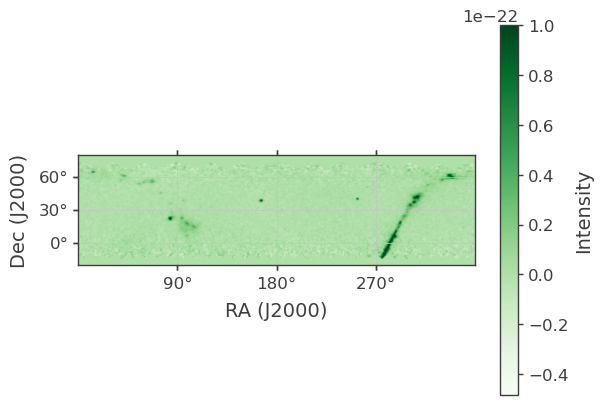

(<Figure size 640x480 with 2 Axes>,
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---CAR'  'DEC--CAR'  
 CRVAL : 180.0  0.0  
 CRPIX : 1799.5  199.5  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : 0.1  0.1  
 NAXIS : 3600  1000,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [53]:
my.drawfits("/data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/WCDA_flux.fits")

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
ait_data = hp.ma(ait_data)
fig, ax = plt.subplots(subplot_kw={'projection': wcs_C})
ax.imshow(ait_data.T)

TypeError: projection must be a string, None or implement a _as_mpl_axes method, not WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1799.5 / Pixel coordinate of reference point            
CRPIX2  =                499.5 / Pixel coordinate of reference point            
CDELT1  =                  0.1 / [deg] Coordinate increment at reference point  
CDELT2  =                  0.1 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---CAR'           / Right ascension, plate caree projection        
CTYPE2  = 'DEC--CAR'           / Declination, plate caree projection            
CRVAL1  =                180.0 / [deg] Coordinate value at reference point      
CRVAL2  =                 30.0 / [deg] Coordinate value at reference point      
LONPOLE =                  0.0 / [deg] Native longitude of celestial pole       
LATPOLE =                 60.0 / [deg] Native latitude of celestial pole        
MJDREF  =                  0.0 / [d] MJD of fiducial time                       
RADESYS = 'ICRS'               / Equatorial coordinate system                   

<Figure size 640x480 with 0 Axes>

In [13]:
skymap = hp.read_map("/data/home/cwy/Science/3MLWCDA/Standard/src/tools/llh_skymap/skytxt/fullsky_WCDA_flux.fits.gz")

In [10]:
ait_data = np.array(ait_data)

In [12]:
np.shape(ait_data)

(3600, 1000)

In [ ]:
ait_data
wcs_galactic = WCS(naxis=2)

In [ ]:
step = 2 * 2 ** (1/2) * 180 / 3.1415926 / 1800
wcs_galactic = WCS(naxis=2)
wcs_galactic.wcs.ctype = ['GLON-AIT', 'GLAT-AIT']
wcs_galactic.wcs.crval = [0, 0]
wcs_galactic.wcs.crpix = [1799.5, 899.5]
wcs_galactic.wcs.cdelt = np.array([step, step])
wcs_galactic.wcs.cunit = ['deg', 'deg']

# filelist = ["data/fits/empty_likelihood_significance_map.fits", "data/fits/fit1-residual_likelihood_significance_map.fits"]
filelist = [f"{savename}.fits"]

for filepath in filelist:
    # directory, filename = os.path.split(filepath)
    output_filepath = "gal-" + filepath
    hdul = fits.HDUList()
    fits_file = fits.open(filepath)
    i = 0
    for hdu in fits_file:
        if i == 1:
            continue
        i = i + 1
        wcs = WCS(hdu.header)
        array, footprint = reproject_interp(hdu, wcs_galactic, shape_out=[1800, 3600], parallel=10)
        gal_header = wcs_galactic.to_header()
        key_list = ["FILENAME", "E_UNIT", "E_L", "E_H"]
        for key in hdu.header:
            if key in key_list:
                gal_header.set(key, hdu.header[key], hdu.header.comments[key])
        hdul.append(fits.ImageHDU(data=array, header=gal_header))
    hdul.writeto(output_filepath, overwrite=True)